# Temperature Visualization, Prediction and Analysis


# Introduction


# 1. Problem

A conventional thermometer requires the thermometer to be at thermal equilibrium with the object to accurately measure the temperature of the object. The time taken to reach thermal equilibrium depends on the heat capacity of the thermometer and heat transfer rate. For example, the thermometer and the temperature sensor provided take __*more than 100 s*__ to reach quasi-thermal equilibrium with a water bath. 

We wish to reduce this waiting time by building a predictive model utilizing temperature and time data taken using the temperature sensor, leveraging on mathematical relations between the quantities and approximations to get correct predictions. 

# 2. Approach

# Terms used:

Variables:

$$1.\:Temperature\:at\:time\:t\: : T_{s}(t)$$

$$2.\:Time\: : t $$

Constants:

$$1.\:Ambient\:Temperature\: : T_{a} $$

$$2.\:Equilibrium\:Temperature\: : T_{w} (constant\:for\:a\:particular \:experiment, \:variable \:for \:multiple \:experiments) $$

# Approximations and Equations:

From Engineering in the Physical World, we know that there are 2 possible approximations one can use in order to get mathematical relations that link the equilibrium temperature, current temperature of the sensor and ambient temperature to the time. 


1. If no work is done on or by sensor:

 $$T_{w}= \frac{C_{s}}{\lambda}.\frac{dT_{s}}{dt} + T_{s}$$
 
 __This equation implies a linear relationship between the temperature and the derivative of the temperature with respect to time.__
 

2. If the former assumption is valid AND if Cs and lambda are independant of the temperature Ts:

 $$Ln(\frac{T_{s}-T_{w}}{T_{a}-T_{w}})= \frac{-t}{\tau}$$ 

 __This equation implies a linear relationship between the natural log term and the time.__

Since the second equation is derived by integrating the first one, it would be redundant to try to utilise both equations together, as that implies both assumptions must be correct. It would be better to treat them as two possibilities, and the most accurate model would result from the correct assumption.

We proceeded to generate one extra feature for each of the two models, using existing data:

1. For the first model $$\frac{dT_{s}}{dt}$$

2. For the second model $$Ln(\frac{T_{s}-T_{w}}{T_{a}-T_{w}})$$

Then we set the y value(to be predicted) as Tw, taking different parameters for both models.


# Summary of Results

We were able to build a model that predicts the equilibrium temperature fairly accurately, within an error of 1 degree, and within a time period of 10 seconds.


In [180]:
#Relevant modules and libraries
from sklearn.metrics import accuracy_score
from scipy.stats import linregress
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from joblib import dump, load
import matplotlib.pyplot as plt
import math

# Description of Data from Experiment

## Data Collection

We used the Adafruit temperature sensor with Raspberry Pi in order to take temperature readings at regular intervals, along with the time data as well. 

We also recorded the Equilibrium temperature separately and included it while preparing the data in a separate column, as that is the value we wish to predict.

__However__, note that we did not take the sensor final reading as the equilibrium temperature, as we did not want to exceed a collection time of 60 seconds for the data. We did this because the water also loses some heat to the air, and over a longer period of time, the equilibrium temperature may be affected. Thus we used an accurate digital thermometer to get the equilibrium temperature instantly and accurately.


## Data Preparation

Steps:
1. Take data from sensor and input it into a csv file into 2 rows, celsius and time.

2. Load the csv file into a dataframe.

3. From this dataframe, store all the readings of each array, except the first 3, as they are usually outlier data that are not part of the general linear trend, and may lead to reduced accuracies. This is because those first 3 readings are when the sensor is dipped into water, and there is probably some adjustment time from the previous state of being at room temperature.

4. Add two more columns to the dataframe, ambient temperature ($T_{a}$) and equilibrium temperature ($T_{w}$). For a particular dataset, there is only a single ambient and equilibrium temperature, so the columns have the same values repeatedly for a single dataset. But these values will vary over multiple datasets.

5. Calculate 2 extra features(given below), and then reduce all columns by 1 row, because derivative[i]=(temp[i]-temp[i-1])/(t[i]-t[i-1]) means that the derivative cannot be calculated for the very first row, as there is no preceding value of temperature or time. Return the dataframe, ready to be split into train and test datasets.

 a. The derivative of the Temperature with respect to time:
 $$\frac{dT_{s}}{dt}$$
 b. The natural log term:
 $$Ln(\frac{T_{s}-T_{w}}{T_{a}-T_{w}})$$

In [181]:
#Step 1:set filenames and equilibrium temperatures to pass to processing function later.

f1="36.csv"
t1=36
f2="47.csv"
t2=47
f3="55.csv"
t3=55
f4="81.csv"
t4=81

def dataread(filename,Tw):
    
    #Step 2: Read the csv file into a dataframe for easier processing.
    df=pd.read_csv(filename) 
    #create empty arrays c(celsius) and t(time) to be filled with clean data(after excluding certain data)
    c=[]
    t=[]
    #Step 3: excluding first 3 rows, as they are usually outlier data that dont help the model to generalise to the desired trend
    for i in range(3,len(df["celsius"])): 
        c.append(df["celsius"][i])
    for i in range(3,len(df["time"])): 
        t.append(df["time"][i])
        
    #create new dataframe to fill with correct data
    data=pd.DataFrame()
    
    #Step 4: create columns of Tw
    

    data["Tw"]=[Tw]*(len(t)-1)
    
    #Step 5: create empty natural log array
    ln=[]
    #calculate the log values and fill in the array
    Ta=df["celsius"][0] #initialise Ambient temperature for use in calculation.
    for i in range(1,len(c)):
        lnterm=np.log((c[i]-Tw)/(Ta-Tw))
        ln.append(lnterm)
    
    #assign the array to the dataframe
    data["lon"]=ln
    
    #create an empty derivative array, so calculated derivative can be filled in.
    d=[None]*len(c) 
    for i in range(1,len(c)):
        d[i]=(c[i]-c[i-1])/(t[i]-t[i-1])
    
    #Start filling from index 1 as the first value of derivative doesnt exist, as there is no previous value of temperature or time
    data["celsius"]=c[1:]
    data["deriv"]=d[1:]
    data["time"]=t[1:]
    
    
    #return the dataframe
    return (data)

#read and process all 4 datafiles
data1=dataread(f1,t1)
data2=dataread(f2,t2)
data3=dataread(f3,t3)
data4=dataread(f4,t4)

In [182]:
data1.head()

,Tw,lon,celsius,deriv,time
0,36,-0.338086,30.250,0.407609,8.04
1,36,-0.453155,30.875,0.355114,9.80
2,36,-0.569305,31.437,0.319318,11.56
3,36,-0.685364,31.937,0.284091,13.32
4,36,-0.816683,32.437,0.284091,15.08


## Data Format

The data has 5 columns:

1.Tw - Equilibrium Temperature

2.Lon - Natural Log of ((T(t)-Tw)/(Ta-Tw)) 

3.Celsius - Recorded Temperature in celsius

4.Deriv(derivative) - Approximate derivative of Temperature with respect to time.


From our earlier 2 equations, we know of two linear relations, either of which can be used to predict Tw. Thus we can build 2 models, one for each relation, and check which one has better accuracy.

# Visualisations

# 1. Proof as to why the data should be cleaned from the first 3 rows, visualisation of unclean data:

Steps:

1. Read csv file into dataframe.
2. Find derivative values for the temperature and time columns.
3. Plot the Temperature vs time using matplotlib, and observe that the first 2 points are outliers(not so obvious as they seem to curve smoothly, but they're not part of the curve formed by the later points).
4. Plot the Derivative vs Temperature. Here we can clearly see the first two points being outliers to the general linear trend.
5. Repeat the above steps for other data files to confirm if these outliers appear in other datasets.
6. Now we have more than enough proof that all the files should be cleaned of the first 3 rows.


Graph of temperature vs time
As you can observe, the first two points dont fit smoothly onto the curve.


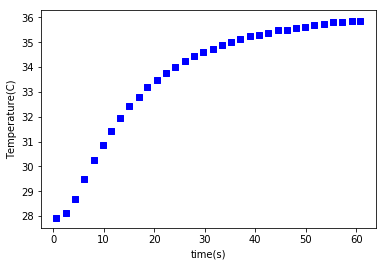

Graph of derivative vs temperature
Except for the first two points, the other points fit relatively well. Hence it is necessary to clean up the first 3 rows, for a good safety margin.


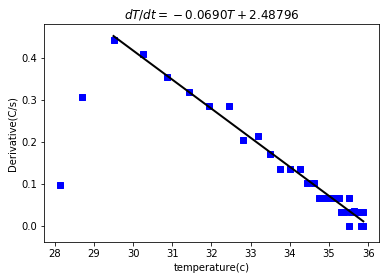

Check in 2nd data file
Graph of temperature vs time
As you can observe, the first two points dont fit smoothly onto the curve.


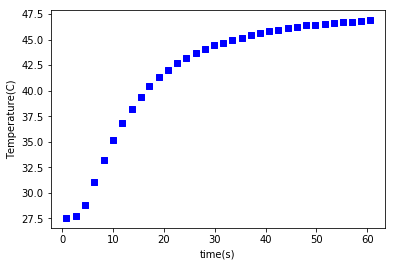

Graph of derivative vs temperature
Except for the first two points, the other points fit relatively well. Hence it is necessary to clean up the first 3 rows, for a good safety margin.


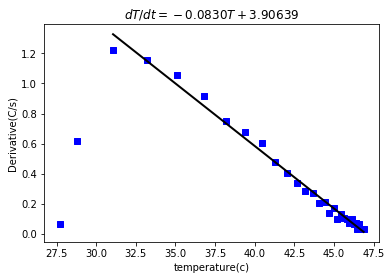

In [183]:
def checkrawdata(f1):
    #step 1, read csv into dataframe
    rawdata=pd.read_csv(f1)
    rawdata.head()
    temp=rawdata["celsius"]
    time=rawdata["time"]
    #step 2, find derivative values
    derivative=[]
    for i in range(1,len(rawdata["celsius"])):
        derivative.append((temp[i]-temp[i-1])/(time[i]-time[i-1]))
    print("Graph of temperature vs time")
    print("As you can observe, the first two points dont fit smoothly onto the curve.")
    #Plot out the temperature vs time
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(time,temp, c='b', marker="s")
    plt.xlabel("time(s)")
    plt.ylabel("Temperature(C)")
    plt.show()
    #plot out the derivative vs the temperature
    print("Graph of derivative vs temperature")
    print("Except for the first two points, the other points fit relatively well. Hence it is necessary to clean up the first 3 rows, for a good safety margin.")
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(temp[1:],derivative, c='b', marker="s")
    #get slope and intercept using linear regression to plot the regression line, and thus see which points are outliers
    slope,intercept,rvalue,pvalue,stderr=(linregress(temp[3:],derivative[2:]))
    plt.xlabel("temperature(c)")
    plt.ylabel("Derivative(C/s)")
    plt.plot([temp[3], temp[len(temp)-1]], [slope*temp[3]+intercept,slope*temp[len(temp)-1]+intercept], color='k', linestyle='-', linewidth=2)
    plt.title('$dT/dt=%3.7sT+%3.7s$'%(slope, intercept))
    plt.show()
    
checkrawdata(f1)
print("Check in 2nd data file")
checkrawdata(f2)

# 2. Visualise 3 graphs for a cleaned dataframe:

a. Temperature vs Time

b. Derivative vs Temperature

c. Natural Log term vs Time

From the following graphs, we can see that our linear equations are valid and can be applied for prediction.
visualising dataset 1
1. Temperature vs Time


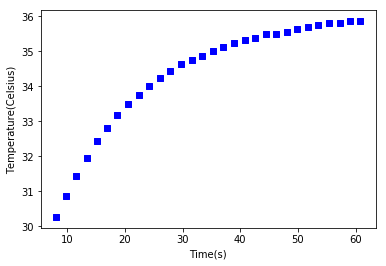

2. Derivative vs Temperature


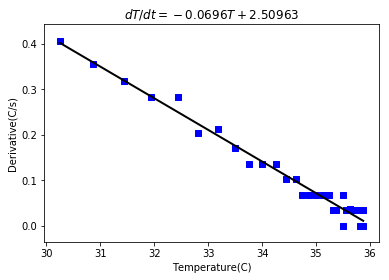

3. -Lon vs Time


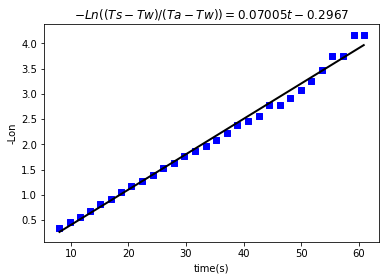

plotting dataset 4 for checking
1. Temperature vs Time


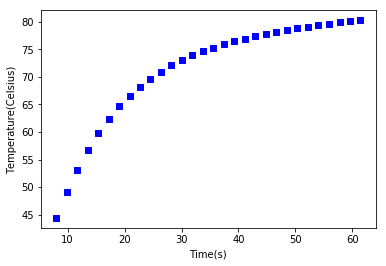

2. Derivative vs Temperature


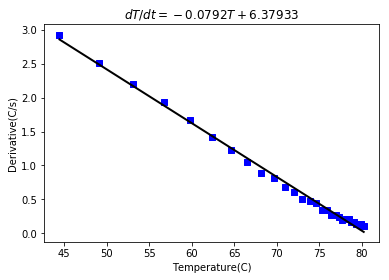

3. -Lon vs Time


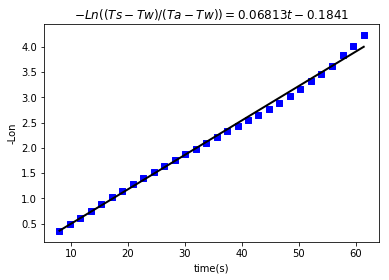

In [184]:
print("From the following graphs, we can see that our linear equations are valid and can be applied for prediction.")
def plot(data1):
    temp=data1["celsius"]
    derivative=data1["deriv"]
    time=data1["time"]
    ln=data1["lon"]
    print("1. Temperature vs Time")
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(time,temp ,  c='b', marker="s", label='deriv')
    plt.xlabel("Time(s)")
    plt.ylabel("Temperature(Celsius)")
    plt.show()
    print("2. Derivative vs Temperature")
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(temp,derivative ,  c='b', marker="s", label='deriv')
    plt.xlabel("Temperature(C)")
    plt.ylabel("Derivative(C/s)")
    slope,intercept,rvalue,pvalue,stderr=(linregress(temp,derivative))
    plt.plot([temp[0], temp[len(temp)-1]], [slope*temp[0]+intercept,slope*temp[len(temp)-1]+intercept], color='k', linestyle='-', linewidth=2)
    plt.title('$dT/dt=%3.7sT+%3.7s$'%(slope, intercept))
    plt.show()
    print("3. -Lon vs Time")
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(time,-ln ,  c='b', marker="s", label='lon')
    plt.xlabel("time(s)")
    plt.ylabel("-Lon")
    slope,intercept,rvalue,pvalue,stderr=(linregress(time,-ln))
    plt.plot([time[0], time[len(temp)-1]], [slope*time[0]+intercept,slope*time[len(time)-1]+intercept], color='k', linestyle='-', linewidth=2)
    plt.title('$-Ln((Ts-Tw)/(Ta-Tw))=%3.7st%3.7s$'%(slope, intercept))
    plt.show()
print("visualising dataset 1")
plot(data1)
print("plotting dataset 4 for checking")
plot(data4)

# 3. Combine datasets to prevent wrong fitting/overfitting

One obvious shortcoming of having the output column Tm as constant for every single row in the dataset is that the model can simply predict Y=Tw for that particular dataset without generalising or getting any slope values for its variables, when model type 1 is used. Thus we need to combine the datasets having different Tw values, in order to train the model properly.

In [185]:
frames=[data1,data2,data3,data4]
#combine all 4 dataframes into 1
alldata=pd.concat(frames)
#reset the index of the concatenated dataframe, otherwise index will go from 0 to n, then 0 to n again, instead of 0 to 2n.
alldata.reset_index(drop=True,inplace=True)

# Training Model

Steps:

1. Decide the features for the model based on the model type chosen, which will determine the X data. If user picks modelnumber=1, then they will be using temperature and derivative features to predict Tw. If modelnumber=2 is chosen, then time will be used to predict the natural log term, and the Tw can be backcalculated from the predicted natural log value. The X 

2. Scaling is an option, which can act as an extra parameter to adjust and maximise accuracy.

3. Split_process_data: Takes in x and y data, and splits the data according to test_size parameter, and reshapes it to fit into the model.

4. Fit the linear regression model on the training data.

5. Use the model to predict from the test dataset, and get the accuracy related measures such as mse, r2, coefficients and intercepts.

6. Calculate and display the accuracy and average absolute errors based on which model type was chosen.

Describe how you train your model. Include any code and output

In [186]:
def model(data,modelnumber,scale,testsize):
    model=LinearRegression()
    #Step 1: decide features based on the model type chosen
    if modelnumber==1:
        features=["deriv","celsius"]
        y=data["Tw"]  #here Tw is directly predicted
    elif modelnumber==2:
        features=["time"]   
        y=-data["lon"] #slope of line can be used to find tau, which can be used to find Tw
    else:
        print("Wrong model number, only 1 or 2")
        return None
    x=data[features]
    
    #Step 2: Give user the option to check if scaling affects accuracy
    if(scale==True):
    #scale down all features to prevent bias towards large features
        for i in features:
            for j in range(len(x[i])):
                x[i][j]=(x[i][j]-min(x[i]))/(max(x[i])-min(x[i]))
              
    #Step 3: Split the x and y data into training and testing data, in a ratio of 70:30
    #X_train, X_test, y_train, y_test=split_process_data(x,y,testsize)
    X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=testsize,random_state=42)
    #Process data to the correct shape for training
    X_train=np.array(X_train)
    #reshape data based on model type chosen
    if modelnumber==1:
        X_train=X_train.reshape(-1,2)
    if modelnumber==2:
        X_train=X_train.reshape(-1,1)
    y_train=np.array(y_train)
    y_train=y_train.reshape(-1,1)
   
    #Step 4: Fit the linear regression model onto the training data
    model.fit(X_train,y_train)
    #Step 5: Predict values for the Y-test set
    y_pred=model.predict(X_test)
    #Get the error,r2,coefficient and intercept of the model
    mse=mean_squared_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    coeff=model.coef_
    intercept=model.intercept_
    print("r2 score and mean square error",r2,mse)
    print("coeff and intercept are",coeff,intercept)
    
    #Step 6 : Display average errors in predictions based on model type chosen.
    if(modelnumber==1):
        print("y test was(index on left, values on right)")
        print(y_test[:10])
        print("y pred is")
        print(y_pred[:10])
        error=[]
        #due to the random selection of test data, the indexes of y test are not ordered, not starting from 0.
        y_test.reset_index(drop=True,inplace=True)
        for i in range(len(y_test)):
            error.append(abs(y_test[i]-y_pred[i]))
        print("average error in predicting y_pred is")
        avger=sum(error)/len(error)
        print(avger)
            
    if(modelnumber==2):
        Ta=data["celsius"][0]
        tau=1/coeff
        Tw=[]
        error=[]
        for i in range(len(data["celsius"])):
            t=data["time"][i]
            T=data["celsius"][i]
            exponent=(2.71828)**((-t)/(tau))
            predictTw=((T-(Ta*exponent))/(1-exponent))
            Tw.append(predictTw)
            error.append(abs(data["Tw"][i]-predictTw))
        avger=sum(error)/len(error)
        print("average error is",avger)
    return model,avger

# 1.Find average error for different model, scale choice, and test size.

Plot out the errors vs the test size first to see what sort of test size works best.
Modeltest: Input your modeltype and scale, and it will display how the avg error varies for test_sizes ranging from 0.3 to 0.6. It calls the model for your specified paramters, and for test size specified.

[0.30000000000000004, 0.4, 0.5, 0.6000000000000001]
r2 score and mean square error 0.9980170782737217 0.5239870661690411
coeff and intercept are [[12.88901513  1.00347453]] [0.12630104]
y test was(index on left, values on right)
44     47
47     47
4      36
55     47
26     36
64     55
73     55
10     36
40     47
107    81
Name: Tw, dtype: int64
y pred is
[[47.47518832]
 [47.28660751]
 [36.33765631]
 [47.35460955]
 [36.49703458]
 [54.09650159]
 [54.24378584]
 [36.24652848]
 [47.46754248]
 [80.31240109]]
average error in predicting y_pred is
[0.55928964]
r2 score and mean square error 0.9975733139911789 0.6641873310115693
coeff and intercept are [[13.14437716  1.00007973]] [0.24630286]
y test was(index on left, values on right)
44     47
47     47
4      36
55     47
26     36
64     55
73     55
10     36
40     47
107    81
Name: Tw, dtype: int64
y pred is
[[47.4858635 ]
 [47.27899894]
 [36.42008707]
 [47.32507225]
 [36.50406646]
 [54.30818876]
 [54.27218295]
 [36.28495437]
 [47.5

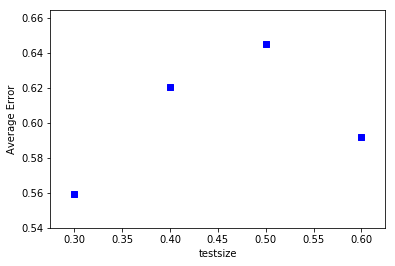

In [187]:
def modeltest(modeltype,scale):
    testsize=[i*0.1 for i in range(3,7)]
    print(testsize)
    errsize1=[]
    for i in [0.3,0.4,0.5,0.6]:
        model1,avger=model(alldata,modeltype,scale,i)
        errsize1.append(avger)
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(testsize,errsize1 , c='b', marker="s")
    plt.xlabel("testsize")
    plt.ylabel("Average Error")
    plt.show()
modeltest(1,False)

[0.30000000000000004, 0.4, 0.5, 0.6000000000000001]


C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


r2 score and mean square error 0.9019002246356423 25.9228656400315
coeff and intercept are [[24.73437931 69.62709175]] [7.01612073]
y test was(index on left, values on right)
44     47
47     47
4      36
55     47
26     36
64     55
73     55
10     36
40     47
107    81
Name: Tw, dtype: int64
y pred is
[[47.49969592]
 [47.50606887]
 [37.56480544]
 [47.75915406]
 [38.3728982 ]
 [51.22421335]
 [52.98826873]
 [37.88279239]
 [47.22102758]
 [80.01991691]]
average error in predicting y_pred is
[2.67326746]


C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


r2 score and mean square error 0.910949000325715 24.373382292795792
coeff and intercept are [[23.43573612 70.53534762]] [6.65131926]
y test was(index on left, values on right)
44     47
47     47
4      36
55     47
26     36
64     55
73     55
10     36
40     47
107    81
Name: Tw, dtype: int64
y pred is
[[47.5685735 ]
 [47.61015645]
 [37.44082532]
 [47.90682512]
 [38.39843117]
 [50.92692639]
 [53.05333345]
 [37.8452246 ]
 [47.22986414]
 [80.16923179]]
average error in predicting y_pred is
[2.73002475]


C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


r2 score and mean square error 0.9163442504014659 20.49974848828788
coeff and intercept are [[23.36178696 70.44275823]] [6.56185407]
y test was(index on left, values on right)
44     47
47     47
4      36
55     47
26     36
64     55
73     55
10     36
40     47
107    81
Name: Tw, dtype: int64
y pred is
[[47.42288278]
 [47.46534681]
 [37.30674388]
 [47.76269903]
 [38.26679446]
 [50.76577972]
 [52.89843442]
 [37.71280357]
 [47.08311557]
 [79.97159025]]
average error in predicting y_pred is
[2.49662311]


C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


r2 score and mean square error 0.9349169543018444 17.01479723091534
coeff and intercept are [[24.54225743 69.18493782]] [7.43484366]
y test was(index on left, values on right)
44     47
47     47
4      36
55     47
26     36
64     55
73     55
10     36
40     47
107    81
Name: Tw, dtype: int64
y pred is
[[47.65929433]
 [47.66638622]
 [37.78612587]
 [47.91873509]
 [38.59209143]
 [51.35119342]
 [53.1113827 ]
 [38.10387199]
 [47.38117617]
 [79.9655696 ]]
average error in predicting y_pred is
[2.41490621]


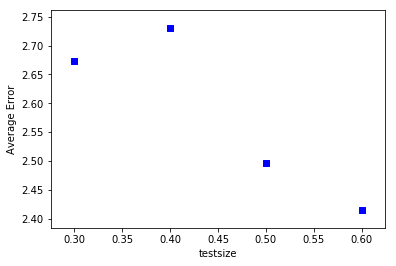

In [188]:
modeltest(1,True)

[0.30000000000000004, 0.4, 0.5, 0.6000000000000001]


C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


r2 score and mean square error 0.9526855239569509 0.05118317928494709
coeff and intercept are [[4.30184087]] [-0.26575681]
average error is [[5.34035833]]


C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


r2 score and mean square error 0.9618882527013101 0.049559850492575115
coeff and intercept are [[4.30212424]] [-0.27001845]
average error is [[5.34035833]]


C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


r2 score and mean square error 0.9623262211992514 0.0440986730182905
coeff and intercept are [[4.31799173]] [-0.28302658]
average error is [[5.34035833]]


C:\Users\rahul\AnacondaReal\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


r2 score and mean square error 0.9570273512613382 0.048923318026272894
coeff and intercept are [[4.41680436]] [-0.3243822]
average error is [[5.34035833]]


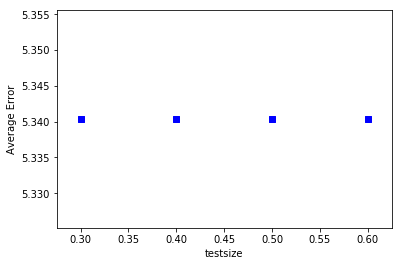

In [189]:
modeltest(2,True)

[0.30000000000000004, 0.4, 0.5, 0.6000000000000001]
r2 score and mean square error 0.9618809891753817 0.04123584002972185
coeff and intercept are [[0.07001801]] [-0.26582231]
average error is [[2.33719409]]
r2 score and mean square error 0.9677017747897376 0.042000047913078604
coeff and intercept are [[0.07002262]] [-0.27008396]
average error is [[2.33758223]]
r2 score and mean square error 0.9677030807945858 0.03780484264852692
coeff and intercept are [[0.07028088]] [-0.28309233]
average error is [[2.35921137]]
r2 score and mean square error 0.9622275139413622 0.043003058976607215
coeff and intercept are [[0.07188919]] [-0.32444945]
average error is [[2.49013531]]


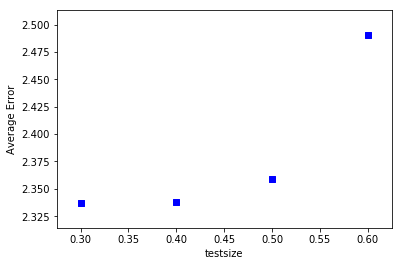

In [190]:
modeltest(2,False)

# Verification and Accuracy

From the above results, we can see that the first model is much better and has a higher R squared value. For a fixed random_state of 42, it has:
r2 score and mean square error 0.9980170782737217 0.5239870661690411
average error in predicting Tw is
[0.55928964]C

Whereas the second model is not as effective:
r2 score and mean square error 0.9618809891753817 0.04123584002972185
average error in predicting Tw is [[2.33719409]]C

The error in the second model can arise through error propagation, since we are not predicting Tw directly, and instead we are first predicting the Natural Log term, and then processing it further to get the Tw value.

Steps taken to improve Accuracy:

1. 1st Model was chosen, as it is much better for prediction than 2nd(the consideration of both models initially was a pre emptive step to improve accuracy).
2. Given above are functions that adjust the test size, model type, and whether scaled data or not. The most optimised choice seems to:

a. Scaled - False - This is a surprising result. It is probably due to loss of information regarding magnitude, which in this case is very important. Unlike a simple classification problem involving other non scientific/non formula based data, this is a scientific experiment where the magnitude of different quantities has a certain order(size) and this is probably very important for prediction.

b. Type - 1 - Expected, as type one directly predicts Tw.

c. Test Size - 0.3 - This is an expected result, since less test size means more training data.


